In [5]:
import pandas as pd
import numpy as np
import seaborn as ns
import matplotlib.pyplot as plt
import teradata 
udaExec = teradata.UdaExec ()

entain=r'C:/Users/apelle/.matplotlib/entain.mplstyle'
plt.style.use(entain)


In [7]:
query='''

with CLV as (
SEL TOP 1600
scores.player_id,
scores.snapshot_date,
scores.model_score,
dc.Country_Desc
FROM dwprodviewsppmbi.Model_Daily_scores scores 
JOIN dim_player dp ON scores.player_id = dp.player_id
JOIN Dim_Player_Account dpa ON dpa.player_id = scores.player_id
JOIN Dim_Country dc ON dpa.country_Cd=dc.Country_CD
LEFT JOIN Dim_Player_Segmentation dps ON dp.player_id = dps.player_id														
LEFT JOIN Dim_Product dprod ON dps.Primary_Wh_Product_Cd = dprod.wh_product_cd	
WHERE 1 = 1
AND  scores.snapshot_date =DATE-1
AND scores.player_id >0 
AND model_description_id IS IN (1,5,9)
AND dp.front_end_cd IN ('pp','pi','py','pe') 
AND dprod.Product_Desc = 'Casino'
AND dc.Country_Desc NOT IN ('united kingdom','Finland','Belarus','Russian Federation','Gibraltar','Sweden','Denmark')
AND model_score >= 4000

ORDER BY model_score DESC
)
,

player AS 
(SEL CASE WHEN clv. player_id IS NULL THEN dplh.player_id ELSE clv.player_id END  player_id,
CASE WHEN clv.player_id IS NULL THEN 'not in clv' ELSE 'in_clv' END AS in_out,
CASE WHEN dplh.Host_Agent_First_Name='VIP NOT Hosted' THEN 'non hosted picked'
WHEN dplh.Host_Agent_First_Name IS NULL THEN 'CLV picked' 
ELSE 'Managed' END AS player_status

FROM clv
Full outer JOIN (SEL * FROM DIM_PLAYER_HOST_LOG dplh 
WHERE host_agent_team IN ('PartyCasino VIP',
'Partycasino Vip team') AND host_end_date>=DATE-1 )  dplh ON clv.player_id=dplh.Player_Id
)



SEL 

player_x.*,
per.played_months,
per.average_montlhy_ngr,
per.total_ngr_last_12m


FROM


(
SEL player.*,
login_name_Txt,
CASE WHEN  conversion_date >=DATE-14 THEN 'New player' ELSE ''  END AS NEW_PLAYER,
Dp.registration_date,
country_Desc,

pp.clvgbp


FROM player
JOIN Dim_Player dp ON player.player_id = dp.PLAYER_ID
JOIN Dim_Player_Account dpa ON dp.Player_Id=dpa.Player_Id
JOIN Dim_Country dc ON dpa.Country_Cd=dc.Country_CD

LEFT JOIN (
SELECT	 
player_id,


mds.snapshot_date,

SUM(CASE WHEN model_description_id IN (3,7,11) THEN model_score ELSE NULL end) CLV_Casino_New,
SUM(CASE WHEN model_description_id IN (3,7,11) THEN model_score * conversion_rate ELSE 0 end)   AS CLVGBP
FROM
dwprodviewsppmbi.Model_Daily_Scores mds

LEFT JOIN 

(
SELECT	fx.conversion_rate,
                 snapshot_date	
FROM DWPRODVIEWSMSTR.Dim_Fx_Snapshot fx
WHERE fx.From_Curr_Cd = 'EUR'
	AND fx.to_curr_cd = 'GBP'
	AND fx.Snapshot_Date >= '2021-01-01' )  fx 
	ON mds.snapshot_date = fx.snapshot_date


WHERE model_description_id IN (3,7,11)
AND mds.snapshot_date = DATE-1
GROUP BY 1,2

) pp  ON player.player_id=pp.player_id
) player_x
 
 LEFT JOIN ( SEL 

player_id,
COUNT(DISTINCT summary_month_Date) played_months,
SUM(ngr_amt_gbp) total_ngr_last_12m,
SUM(ngr_amt_gbp)/COUNT(DISTINCT summary_month_Date) average_montlhy_ngr

FROM FM_Player_Summary fps 

JOIN Dim_Skin ds ON fps.Wh_Skin_Id=ds.Wh_Skin_Id
WHERE fps.Summary_Month_Date BETWEEN ADD_MONTHS ( ( DATE - EXTRACT(DAY FROM DATE)+ 1),-12) AND ADD_MONTHS ( ( DATE - EXTRACT(DAY FROM DATE)+ 1),-1) 
AND ds.Wh_Product_Cd=2

GROUP BY 1) per ON player_x.player_id=per.player_id
'''

In [8]:
#Run query
with udaExec.connect("${dataSourceName}") as session:
    
    df=pd.read_sql_query(query,session)

session.close()

In [9]:
df.head()

,player_id,in_out,player_status,Login_Name_Txt,NEW_PLAYER,Registration_Date,Country_Desc,CLVGBP,played_months,average_montlhy_ngr,total_ngr_last_12m
0,22300035.0,not in clv,non hosted picked,pp_pepirocks,,2006-11-26,Austria,5162.013115,12.0,471.42592,5657.11099
1,555810875.0,in_clv,non hosted picked,pp_Tayo448844,,2021-01-02,Canada,4597.224115,11.0,904.28291,9947.11205
2,558371035.0,not in clv,Managed,pe_The_pink,,2021-02-25,Spain,1018.313774,9.0,-429.58963,-3866.30666
3,529569437.0,in_clv,non hosted picked,pp_Terry952,,2019-12-18,Canada,11158.152261,2.0,4979.28145,9958.56289
4,21804183.0,not in clv,Managed,pp_ph1501,,2006-10-28,Austria,NaN,NaN,NaN,NaN


In [12]:
df.columns=df.columns.str.replace(' ','')
df=df.replace("'",'')
df.rename(columns={'Summary_Date':'date'},inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2852 entries, 0 to 2851
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player_id            2852 non-null   float64
 1   in_out               2852 non-null   object 
 2   player_status        2852 non-null   object 
 3   Login_Name_Txt       2852 non-null   object 
 4   NEW_PLAYER           2852 non-null   object 
 5   Registration_Date    2852 non-null   object 
 6   Country_Desc         2852 non-null   object 
 7   CLVGBP               2713 non-null   float64
 8   played_months        2705 non-null   float64
 9   average_montlhy_ngr  2705 non-null   float64
 10  total_ngr_last_12m   2705 non-null   float64
 11  est_CLV              2713 non-null   float64
 12  player_n             2852 non-null   int64  
dtypes: float64(6), int64(1), object(6)
memory usage: 289.8+ KB


In [11]:
df['est_CLV']= df['CLVGBP']/12
df['player_n']=1

In [10]:
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles

In [16]:
df.player_status.unique()

array(['CLV picked', 'Managed', 'non hosted picked'], dtype=object)

In [13]:
vit_prosp=df[(df['player_status']=='non hosted picked') & (df['in_out']=='not in clv')]
prosp_overlap=df[(df['player_status']=='non hosted picked') & (df['in_out']!='not in clv')]
vit_man=df[(df['player_status']=='Managed') & (df['in_out']=='not in clv')]
man_overalp=df[(df['player_status']=='Managed') & (df['in_out']!='not in clv')]
clv_ignored=df[(df['player_status']=='CLV picked') & (df['in_out']!='not in clv')]


In [39]:
man_overalp.to_clipboard()

In [14]:
set_a=df[(df['player_status']=='non hosted picked') & (df['in_out']=='not in clv')].player_id.count()
set_b=df[(df['player_status']=='non hosted picked') & (df['in_out']!='not in clv')].player_id.count()
set_c=df[(df['player_status']=='Managed') & (df['in_out']=='not in clv')].player_id.count()
set_d=df[(df['player_status']=='Managed') & (df['in_out']!='not in clv')].player_id.count()
set_e=df[(df['player_status']=='CLV picked') & (df['in_out']!='not in clv')].player_id.count()

set_z=df[(df['player_status']!='Managed') & (df['in_out']!='not in clv')].player_id.count()

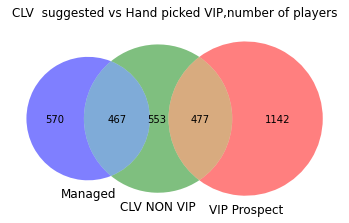

In [30]:
venn3(subsets = (set_a, set_e, set_b, set_d,0,set_c,0), set_labels = ('VIP Prospect', 'CLV NON VIP', 'Managed'), alpha = 0.5);
plt.title('CLV  suggested vs Hand picked VIP,number of players');

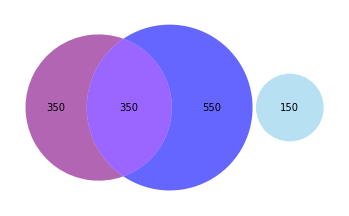

In [51]:
venn3(subsets = (350,900-350, 350,150,0,0,0), set_labels = (''),set_colors=('purple','blue', 'skyblue'),alpha = 0.6,);

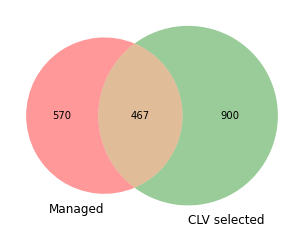

In [25]:
venn2(subsets=(350,,467),set_labels=('Managed','CLV selected') )

In [40]:
df[(df['player_status']=='CLV picked') & (df['in_out']!='not in clv')].groupby('Country_Desc')['player_id'].count()

Country_Desc
Austria         35
Brazil           9
Canada         397
Chile            2
Hungary          7
Iceland          1
Ireland          6
Italy            5
Kazakhstan       2
Luxembourg       3
Malta           10
Mexico           5
Moldova          1
Morocco          1
Netherlands      6
New Zealand      1
Paraguay         2
Slovenia        21
Spain           35
Uzbekistan       4
Name: player_id, dtype: int64

In [84]:
query2='''
SEL

fps.Player_Id,
dp.Login_Name_Txt,
dplh.Host_Start_Date,
CASE WHEN dplh.Host_Agent_First_Name='VIP NOT Hosted' THEN 'non hosted picked' ELSE 'managed' END AS status,
scores.model_score est_ngr_pre_host,
scores.model_score /365 AS CLV_daily_ngr_pre,
scores2.model_score /365 AS CLV_daily_ngr_post,
COUNT(DISTINCT fps.Summary_Date) days_played,
(DATE-1-dplh.Host_Start_Date) days_since_host,
(dplh.Host_Start_Date-DATE '2021-01-01') AS days_pre_host,
SUM(fps.ngr_amt_eur) ngr_eur,

SUM(CASE WHEN fps.Summary_Date>= dplh.Host_Start_Date THEN fps.NGR_Amt_EUR ELSE 0 END ) / (days_since_host)  daily_hosted_ngr,
SUM(CASE WHEN fps.Summary_Date< dplh.Host_Start_Date THEN fps.NGR_Amt_EUR ELSE 0 END ) /NULLIF( days_pre_host,0)  daily_non_hosted_ngr




FROM FD_Player_Summary fps 
JOIN Dim_Skin ds ON fps.Wh_Skin_Id=fps.Wh_Skin_Id
JOIN Dim_Player dp ON fps.Player_Id=dp.Player_Id
JOIN (SELECT * FROM Dim_Player_host_log  WHERE host_agent_team IN ('PartyCasino VIP',
'Partycasino Vip team') )  dplh ON fps.Player_Id = dplh.Player_Id 
JOIN dwprodviewsppmbi.Model_Daily_scores scores ON fps.Player_Id=scores.player_id AND dplh.Host_Start_Date-1 =scores.snapshot_date
JOIN dwprodviewsppmbi.Model_Daily_scores scores2 ON fps.Player_Id=scores2.player_id AND DATE-1 =scores2.snapshot_date

WHERE fps.Summary_Date>= '2021-01-01' 
AND ds.Wh_Product_Cd=2
AND scores.model_description_id IS IN (1,5,9)
AND scores2.model_description_id IS IN (1,5,9)
AND dplh.Host_End_Date>=DATE-1
AND dplh.Host_Start_Date>='2021-01-01'

GROUP BY 1,2,3,4,5,6,7  '''

In [85]:
#Run query
with udaExec.connect("${dataSourceName}") as session:
    
    df2=pd.read_sql_query(query2,session)

session.close()

In [86]:
df2.head()

,Player_Id,Login_Name_Txt,Host_Start_Date,status,est_ngr_pre_host,CLV_daily_ngr_pre,CLV_daily_ngr_post,days_played,days_since_host,days_pre_host,ngr_eur,daily_hosted_ngr,daily_non_hosted_ngr
0,516015321.0,pp_Paparazzi79,2021-10-07,non hosted picked,12688.476804,34.762950,17.409918,76.0,55.0,279.0,2.269427e+06,3161.72477,7510.86626
1,518807999.0,pp_Molsonmax10,2021-08-06,managed,11211.059955,30.715233,3.791432,179.0,117.0,217.0,1.171596e+07,45295.76830,29568.44816
2,413737293.0,pp_sofiane2589,2021-10-07,non hosted picked,5316.173791,14.564860,16.852320,74.0,55.0,279.0,5.240948e+06,9418.99752,16927.96692
3,534399822.0,pp_ktmexc450r04,2021-11-08,non hosted picked,2318.779122,6.352820,9.134238,83.0,23.0,311.0,3.758285e+06,27820.22703,10027.07225
4,550141644.0,pp_Majorgambit,2021-10-06,managed,18889.786865,51.752841,47.631104,264.0,56.0,278.0,1.214600e+07,35754.94164,36488.21768


In [47]:
up_up=df2[(df2['daily_hosted_ngr']>df2['CLV_daily_ngr_pre'])  &  (df2['CLV_daily_ngr_post']>df2['CLV_daily_ngr_pre'])]
up=df2[(df2['daily_hosted_ngr']>df2['CLV_daily_ngr_pre'])  &  (df2['CLV_daily_ngr_post']<df2['CLV_daily_ngr_pre'])]
down_down=df2[(df2['daily_hosted_ngr']<df2['CLV_daily_ngr_pre'])  &  (df2['CLV_daily_ngr_post']<df2['CLV_daily_ngr_pre'])]
down=df2[(df2['daily_hosted_ngr']<df2['CLV_daily_ngr_pre'])  &  (df2['CLV_daily_ngr_post']>df2['CLV_daily_ngr_pre'])]

In [68]:
up_up[up_up['status']=='managed'].Player_Id.count()
up[up['status']=='managed'].Player_Id.count()
down[down['status']=='managed'].Player_Id.count()
down_down[down_down['status']=='managed'].Player_Id.count()


#df2[df2['status']=='managed'].Player_Id.count()

112

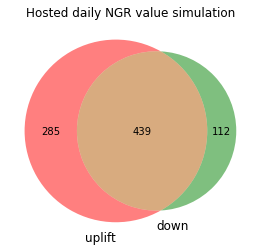

In [77]:
venn2(subsets = (up_up[up_up['status']=='managed'].Player_Id.count(),
down_down[down_down['status']=='managed'].Player_Id.count(),
up[up['status']=='managed'].Player_Id.count()+down[down['status']=='managed'].Player_Id.count()
,0,0),      
set_labels = ('uplift', 'down','disagree') , alpha = 0.5);
plt.title('Hosted daily NGR value simulation');

In [52]:
up_up

,Player_Id,Login_Name_Txt,Host_Start_Date,status,est_ngr_pre_host,CLV_daily_ngr_pre,CLV_daily_ngr_post,days_played,days_since_host,days_pre_host,ngr_eur,daily_hosted_ngr,daily_non_hosted_ngr
2,413737293.0,pp_sofiane2589,2021-10-07,non hosted picked,5316.173791,14.564860,16.852320,74.0,55.0,279.0,5.240948e+06,9418.99752,16927.96692
3,534399822.0,pp_ktmexc450r04,2021-11-08,non hosted picked,2318.779122,6.352820,9.134238,83.0,23.0,311.0,3.758285e+06,27820.22703,10027.07225
5,575848730.0,pp_Luciana7677,2021-10-28,managed,300.233301,0.822557,0.847593,18.0,34.0,300.0,6.742120e+04,1857.90746,14.17449
7,556703473.0,pe_Emilio323,2021-03-09,managed,6786.878021,18.594186,22.619085,79.0,267.0,67.0,7.400365e+06,19724.71940,31848.72655
15,534735805.0,pp_BlairEllery68,2021-05-17,managed,35650.697202,97.673143,106.165982,146.0,198.0,136.0,4.088770e+07,107308.94415,144415.62182
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2281,196688659.0,pp_stuartdrj,2021-11-08,non hosted picked,5461.961717,14.964279,26.095661,101.0,23.0,311.0,3.327925e+06,54151.01501,6695.98530
2282,193089807.0,pp_sernek16,2021-10-07,non hosted picked,5054.171744,13.847046,14.711044,26.0,55.0,279.0,2.312791e+06,12991.67786,5728.48940
2286,555658772.0,pp_Michelle028299,2021-02-01,managed,13496.700955,36.977263,53.676472,275.0,303.0,31.0,2.205420e+07,64186.25719,84056.97712
2288,482849977.0,pp_bauhaus13cl,2021-11-08,managed,7095.173897,19.438833,24.711385,51.0,23.0,311.0,1.206814e+07,76004.79679,33183.35932


In [80]:
up_up.groupby('status').sum()[['CLV_daily_ngr_pre','CLV_daily_ngr_post','daily_hosted_ngr',]]

,CLV_daily_ngr_pre,CLV_daily_ngr_post,daily_hosted_ngr
status,,,
managed,8513.987442,13888.662623,2.206142e+07
non hosted picked,6280.268290,8333.999974,9.149607e+06


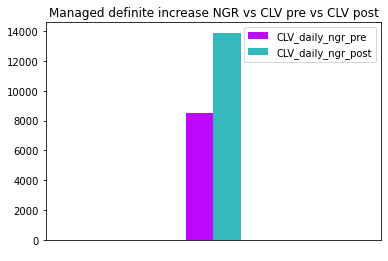

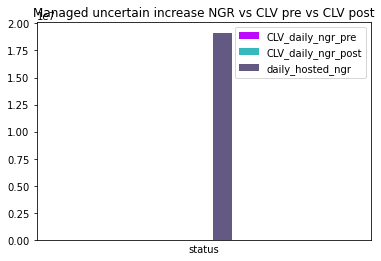

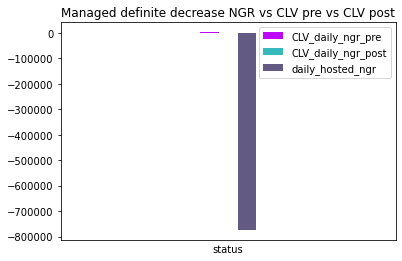

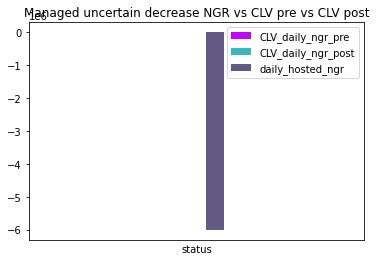

In [83]:
fig1=up_up[up_up['status']=='managed'].groupby('status').sum()[['CLV_daily_ngr_pre','CLV_daily_ngr_post',]].plot.bar(width=0.1)
fig1=plt.xlabel(' ')
fig1=plt.title('Managed definite increase NGR vs CLV pre vs CLV post')


plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

fig2=up[up['status']=='managed'].groupby('status').sum()[['CLV_daily_ngr_pre','CLV_daily_ngr_post','daily_hosted_ngr',]].plot.bar(width=0.1)
fig2=plt.title('Managed uncertain increase NGR vs CLV pre vs CLV post')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off


fig3=down_down[down_down['status']=='managed'].groupby('status').sum()[['CLV_daily_ngr_pre','CLV_daily_ngr_post','daily_hosted_ngr',]].plot.bar(width=0.1)
fig3=plt.title('Managed definite decrease NGR vs CLV pre vs CLV post')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

fig4=down[down['status']=='managed'].groupby('status').sum()[['CLV_daily_ngr_pre','CLV_daily_ngr_post','daily_hosted_ngr',]].plot.bar(width=0.1)
fig4=plt.title('Managed uncertain decrease NGR vs CLV pre vs CLV post')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off



plt.legend()


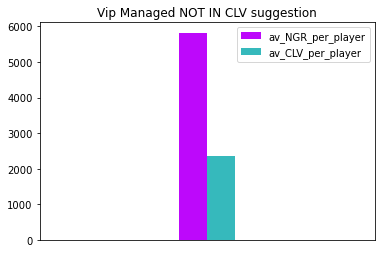

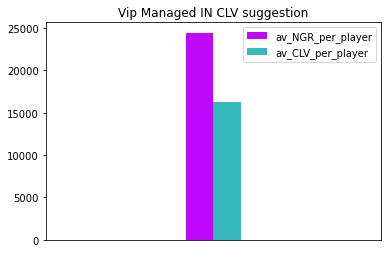

In [127]:
fig1=group1[(group1['player_status']=='Managed') & (group1['in_out']=='not in clv')][['av_NGR_per_player','av_CLV_per_player']].plot.bar(width=0.1)
fig1=plt.xlabel(' ')
fig1=plt.title('Vip Managed NOT IN CLV suggestion')


plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

fig2=group1[(group1['player_status']=='Managed') & (group1['in_out']!='not in clv')][['av_NGR_per_player','av_CLV_per_player']].plot.bar(width=0.1,secondary_y=False)
fig2=plt.xlabel(' ')
fig2=plt.title('Vip Managed IN CLV suggestion')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.legend()


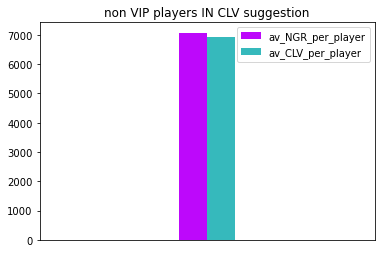

In [128]:
fig1=group1[(group1['player_status']=='CLV picked') & (group1['in_out']!='not in clv')][['av_NGR_per_player','av_CLV_per_player']].plot.bar(width=0.1)
fig1=plt.xlabel(' ')
fig1=plt.title('non VIP players IN CLV suggestion')


plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off


